In [167]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('./../../../../')
sys.path.append('./../../../script/')
sys.path.append('./')
sys.path.append('./designer/script/')

from tmm.get_E import get_E_free
from tmm.get_jacobi_arb_adjoint import get_jacobi_E_free_form
from tmm.get_jacobi_adjoint import get_jacobi_adjoint
from tmm.get_spectrum import get_spectrum_free
from film import FreeFormFilm, TwoMaterialFilm
from tmm.autograd_wrapper import *
from tmm.E_to_spectrum import *

import matplotlib.pyplot as plt
import numpy as np



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Manual diff

# autograd r

In [168]:
# autograd

# set exp 
wls = np.linspace(500, 1000, 500)
inc_ang = 60.
np.random.seed(0)
film = FreeFormFilm(np.random.rand(20) * 1 + 1.5, 1000, 2)
d = film.get_d()
n_layers, n_sub, n_inc = film.calculate_n_array(wls), film.calculate_n_sub(wls), film.calculate_n_inc(wls)


# objective: 0.5
def loss_fn(E):
    e = E_to_R(E)
    dif = e - 0.5
    return dif.square().sum()

jacobi_auto = get_jacobi_warpper(loss_fn)
jacobi = np.zeros((wls.shape[0] * 4, d.shape[0], 2, 2))


jacobi_y_wrt_E, jacobi_E_wrt_M, jacobi_M_wrt_x, jacobi = jacobi_auto(    
    jacobi,
    wls,
    d,
    n_layers,
    n_sub,
    n_inc,
    inc_ang,    
    yield_intermediate=True, 
)

E_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)



In [173]:
# test y wrt E
loss_old = loss_fn(torch.tensor(E_gt))
E_new = E_gt.copy()
E_new[0, 0] += 1e-6
loss_new = loss_fn(torch.tensor(E_new))
print((loss_new - loss_old) * 1e6)
print(jacobi_y_wrt_E[0, 0])

# test E wrt x
E_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
E_gt_n = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
d_old = film.get_d().copy()
d = d_old.copy()
d[0] += 1e-6
film.update_d(d)
get_E_free(
    E_gt_n, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
film.update_d(d_old)

print((E_gt_n - E_gt) * 1e6)
print((jacobi_E_wrt_M * jacobi_M_wrt_x).sum((-1, -2))[:, 0])

# test E wrt W
# manually add 1e-5 to M00 in get_E to get E_gt_new
if False:
    E_gt_new = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
    get_E_free(
        E_gt_new, 
        wls, 
        film.get_d(), 
        film.calculate_n_array(wls), 
        film.calculate_n_sub(wls), 
        film.calculate_n_inc(wls), 
        inc_ang, 
    )

    print(jacobi_E_wrt_M[:, 0, 0, 0])
    print((E_gt_new - E_gt_old) / 1e-5)


# test W wrt x
def get_M(
    jacobi,
    wls,
    d,
    n_layers,
    n_sub,
    n_inc,
    inc_ang,    
):
    wls = torch.tensor(wls)
    d = torch.tensor(d)
    n_layers = torch.tensor(n_layers)
    n_inc = torch.tensor(n_inc)
    inc_ang = torch.tensor(inc_ang)
    
    wls = wls.unsqueeze(-1)
    cos = torch.sqrt(
        1 - ((n_inc.unsqueeze(-1) / n_layers) * torch.sin(inc_ang)) ** 2)
    phi = 2 * torch.pi * 1j * cos * n_layers * d / wls
    coshi = torch.cosh(phi)
    sinhi = torch.sinh(phi)
    M = torch.zeros_like(jacobi_M_wrt_x, dtype=torch.complex128)

    s_idx = torch.hstack((torch.arange(wls.shape[0]), torch.arange(2 * wls.shape[0], 3 * wls.shape[0])))
    p_idx = torch.hstack((torch.arange(wls.shape[0], 2 * wls.shape[0]), torch.arange(3 * wls.shape[0], 4 * wls.shape[0])))

    M[s_idx, :, 0, 0] = (coshi).repeat(2, 1).to(jacobi.device)
    M[s_idx, :, 0, 1] = (sinhi / cos / n_layers).repeat(2, 1).to(jacobi.device)
    M[s_idx, :, 1, 0] = (cos * n_layers * sinhi).repeat(2, 1).to(jacobi.device)
    M[s_idx, :, 1, 1] = (coshi).repeat(2, 1).to(jacobi.device)

    M[p_idx, :, 0, 0] = (coshi).repeat(2, 1).to(jacobi.device)
    M[p_idx, :, 0, 1] = (sinhi * n_layers / cos).repeat(2, 1).to(jacobi.device)
    M[p_idx, :, 1, 0] = (cos / n_layers * sinhi).repeat(2, 1).to(jacobi.device)
    M[p_idx, :, 1, 1] = (coshi).repeat(2, 1).to(jacobi.device)
    return M

M = get_M(
    jacobi,
    wls,
    d,
    n_layers,
    n_sub,
    n_inc,
    inc_ang, 
)
d_new = film.get_d().copy()
d_new[0] += 1e-5
M_new = get_M(
    jacobi,
    wls,
    d_new,
    n_layers,
    n_sub,
    n_inc,
    inc_ang, 
)

print((M_new - M)[:, 0, :, :] * 1e5)
# NOTE: diff here is unstable?
print(jacobi_M_wrt_x[:, 0, :, :])



tensor(-1.1603e-05, dtype=torch.float64)
tensor(-1.1606e-05-0.0039j, device='cuda:0', dtype=torch.complex128)
[[ 0.04446694-0.00623255j  0.00187362+0.00704814j]
 [ 0.04424279-0.00986498j  0.00228878+0.00971502j]
 [ 0.04389017-0.01349114j  0.0027592 +0.01238624j]
 ...
 [ 0.0144423 +0.01963471j -0.00744382+0.00678063j]
 [ 0.01464664+0.01944439j -0.00745216+0.00673402j]
 [ 0.01484811+0.01925218j -0.00746009+0.00668719j]]
tensor([ 0.0445-0.0062j,  0.0442-0.0099j,  0.0439-0.0135j,  ...,
        -0.0074+0.0068j, -0.0075+0.0067j, -0.0075+0.0067j], device='cuda:0',
       dtype=torch.complex128)
tensor([[[-0.0219+0.0000j,  0.0000+0.0033j],
         [ 0.0000+0.0136j, -0.0219+0.0000j]],

        [[-0.0218+0.0000j,  0.0000+0.0033j],
         [ 0.0000+0.0137j, -0.0218+0.0000j]],

        [[-0.0218+0.0000j,  0.0000+0.0034j],
         [ 0.0000+0.0138j, -0.0218+0.0000j]],

        ...,

        [[-0.0068+0.0000j,  0.0000+0.0191j],
         [ 0.0000+0.0045j, -0.0068+0.0000j]],

        [[-0.0068+0.000

In [174]:
jacobian_gt = np.zeros((wls.shape[0] * 2, film.get_d().shape[0]))
get_jacobi_adjoint(
    jacobian_gt, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
spec_gt = np.zeros((wls.shape[0] * 2))
get_spectrum_free(
    spec_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
grad_gt = 8 * jacobian_gt[:wls.shape[0], :].T * (spec_gt[:wls.shape[0]] - 0.5)

print('gt: analytic')
print(grad_gt.sum(-1))

grad_diff = np.zeros(film.get_layer_number())
for i in range(film.get_layer_number()):
    d_original = film.get_d().copy()
    d = d_original.copy()
    d[i] += 1e-5
    film.update_d(d)
    spec_gt_var = np.zeros((wls.shape[0] * 2))
    get_spectrum_free(
        spec_gt_var, 
        wls, 
        film.get_d(), 
        film.calculate_n_array(wls), 
        film.calculate_n_sub(wls), 
        film.calculate_n_inc(wls), 
        inc_ang, 
    )
    film.update_d(d_original)
    grad_diff[i] = (np.square(spec_gt_var - 0.5).sum() - np.square(spec_gt - 0.5).sum()) / 1e-5
print('gt: diff')
print(grad_diff)

print('autograd')
print(2 * jacobi)

gt: analytic
[ 0.18052409  0.08108158  0.08882581  0.04742077  0.05128622 -0.10153213
 -0.15792294  0.09287371  0.05210349  0.01948709  0.12095558  0.06449845
  0.07955915 -0.15797572  0.07643038  0.08948597  0.0305142   0.09187629
  0.13207279  0.14224309]
gt: diff
[ 0.18052413  0.08108161  0.08882583  0.04742078  0.05128625 -0.1015321
 -0.15792294  0.09287373  0.05210351  0.01948711  0.1209556   0.06449847
  0.07955917 -0.15797566  0.07643042  0.08948602  0.03051424  0.0918763
  0.13207279  0.1422431 ]
autograd
tensor([ 0.1805,  0.0811,  0.0888,  0.0474,  0.0513, -0.1015, -0.1579,  0.0929,
         0.0521,  0.0195,  0.1210,  0.0645,  0.0796, -0.1580,  0.0764,  0.0895,
         0.0305,  0.0919,  0.1321,  0.1422], device='cuda:0',
       dtype=torch.float64)


# test ellipsometry

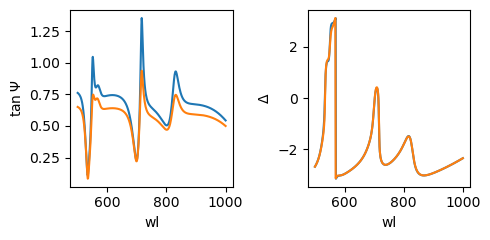

In [176]:
# set exp 
wls = np.linspace(500, 1000, 500)
inc_ang = 45.
np.random.seed(0)
film = TwoMaterialFilm(2.5, 1.5, 2, np.random.random(20) * 100)
d = film.get_d()
n_layers, n_sub, n_inc = film.calculate_n_array(wls), film.calculate_n_sub(wls), film.calculate_n_inc(wls)

tanpsi = np.arctan(film.get_spec(inc_ang, wls).get_tanPsi())
delta = film.get_spec(inc_ang, wls).get_delta()

# target spec
np.random.seed(10)
film_target = TwoMaterialFilm(2.5, 1.5, 2, np.random.random(20) * 1 - 0.5 + film.get_d())
E_target = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_target, 
    wls, 
    film_target.get_d(), 
    film_target.calculate_n_array(wls), 
    film_target.calculate_n_sub(wls), 
    film_target.calculate_n_inc(wls), 
    inc_ang, 
)
E_target = torch.tensor(E_target)
target_psi = E_to_Psi(E_target)
target_edelta = E_to_ephase(E_target)

# test spectra
fig, ax = plt.subplots(1, 2)
ax[0].plot(wls, (target_psi), label='pert')
ax[0].plot(wls, np.arctan(tanpsi), label='seed: 0')
ax[1].plot(wls, torch.angle(target_edelta), label='pert')
ax[1].plot(wls, delta, label='seed: 0')
           

for axi in ax:
    axi.set_xlabel('wl')
ax[0].set_ylabel('$\\tan \\Psi$')
ax[1].set_ylabel('$\\Delta$')

fig.set_size_inches(5, 2.5)
fig.tight_layout()

# ax[1].set_ylim(1.4, 3)

In [177]:
# autograd grad: tan2psi

def loss_fn(E):
    e = E_to_R(E) # NOTE: we want psi because tanpsi is not bounded. delta is okay though
    dif = e - target_psi.to(e.device)
    return dif.abs().square().sum()

jacobi_auto = get_jacobi_warpper(loss_fn)
jacobi = np.zeros((wls.shape[0] * 4, film.get_d().shape[0], 2, 2))

jacobi = jacobi_auto(    
    jacobi,
    wls,
    film.get_d(),
    n_layers,
    n_sub,
    n_inc,
    inc_ang,    
)

print(jacobi)

# diff

grad_diff = np.zeros(film.get_layer_number())

spec_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    spec_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
for i in range(film.get_layer_number()):
    d_original = film.get_d().copy()
    d = d_original.copy()
    d[i] += 1e-5
    film.update_d(d)
    spec_gt_var = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
    get_E_free(
        spec_gt_var, 
        wls, 
        film.get_d(), 
        film.calculate_n_array(wls), 
        film.calculate_n_sub(wls), 
        film.calculate_n_inc(wls), 
        inc_ang, 
    )
    film.update_d(d_original)
    grad_diff[i] = (loss_fn(spec_gt_var) - loss_fn(spec_gt)) / 1e-5
print('gt: diff')
print(grad_diff)


tensor([ 0.3479,  0.4863,  1.2906,  0.9227,  1.7058,  0.9653,  1.3568,  0.5798,
         1.0458,  0.9608,  1.1409,  0.3612,  0.0876,  0.2163,  1.4272,  0.2512,
         1.3398,  0.2764, -0.0767, -0.1879], device='cuda:0',
       dtype=torch.float64)
gt: diff
[ 0.34786595  0.48625866  1.29064858  0.92275297  1.70578952  0.96527066
  1.35683677  0.57975399  1.04575303  0.96077972  1.14090857  0.36124564
  0.0876242   0.21633337  1.42720854  0.25117677  1.33977495  0.27639542
 -0.076698   -0.18793856]
